In [1]:
import matplotlib.pyplot as plt
import optuna
import numpy as np
from optuna.samplers import TPESampler

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp
from snn.resonator import lp_by_lf, freq_of_resonator


In [2]:
from optuna.trial import TrialState


def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0, cycles=5):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((8+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (8/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def resonator_from_optuna(freq0, lf_lp_option, theta_input,
                          theta1, theta2, theta3,
                          weight_input, weight_feedback,
                          weight1, weight2, weight3,
                          clk_freq):
    LF = lf_lp_option
    LP = lp_by_lf(LF, freq0, clk_freq)
    f_resonator = freq_of_resonator(clk_freq, LF, LP)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    weights = [weight1, weight2, weight3]
    thetas = [theta1, theta2, theta3]
    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def objective3(trial):
    gain = 1
    weight_input=trial.suggest_int('weight_input', int(gain*1), int(gain*30))
    weight_feedback=trial.suggest_int('weight_feedback', int(gain*1), int(gain*20))
    weight = trial.suggest_int('weight', int(gain*1), int(gain*20))

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            return previous_trial.value

    resonator = resonator_from_optuna(
        freq0, lf,
        -1,
        -5,
        -5,
        -5,
        weight_input,
        weight_feedback,
        weight,
        weight,
        weight,
        clk_freq)
    return  score_resonator(resonator, duration=duration, freq0=freq0)

def objective5(trial):
    gain = 1
    theta_input=trial.suggest_int('theta_input', -int(gain*13), -int(gain*1))
    theta = trial.suggest_int('theta', -int(gain*13), -int(gain*1))
    weight_input=trial.suggest_int('weight_input', int(gain*1), int(gain*30))
    weight_feedback=trial.suggest_int('weight_feedback', int(gain*1), int(gain*20))
    weight = trial.suggest_int('weight', int(gain*1), int(gain*20))

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            return previous_trial.value

    resonator = resonator_from_optuna(
        freq0, lf,
        theta_input,
        theta,
        theta,
        theta,
        weight_input,
        weight_feedback,
        weight,
        weight,
        weight,
        clk_freq)
    return  score_resonator(resonator, duration=duration, freq0=freq0)

def objective(trial):
    gain = 1
    theta_input=trial.suggest_int('theta_input', -int(gain*13), -int(gain*1))
    theta1 = trial.suggest_int('theta1', -int(gain*13), -int(gain*1))
    theta2 = trial.suggest_int('theta2', -int(gain*13), -int(gain*1))
    theta3 = trial.suggest_int('theta3', -int(gain*13), -int(gain*1))
    weight_input=trial.suggest_int('weight_input', int(gain*1), int(gain*27))
    weight_feedback=trial.suggest_int('weight_feedback', int(gain*1), int(gain*15))
    weight1 = trial.suggest_int('weight1', int(gain*1), int(gain*20))
    weight2 = trial.suggest_int('weight2', int(gain*1), int(gain*20))
    weight3 = trial.suggest_int('weight3', int(gain*1), int(gain*20))

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            return previous_trial.value

    resonator = resonator_from_optuna(
        freq0, lf,
        theta_input,
        theta1,
        theta2,
        theta3,
        weight_input,
        weight_feedback,
        weight1,
        weight2,
        weight3,
        clk_freq)
    return  score_resonator(resonator, duration=duration, freq0=freq0)

def score_resonator(resonator, duration, freq0, plot=False, cycles=5):
    for i in range(0, 5):
        resonator.log_out_spikes(i)

    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

    try:
        spikes_roll = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0, cycles=cycles)
                                for i in range(0, 5)])
    except ValueError:
        return np.inf

    if plot:
        for i in range(5):
            plt.plot(spikes_roll[i], label=f'output of {i}')
        plt.legend()
    mse = 0
    # for i in range(3, 4):
    for i in range(0, 4):
        mse += ((ground_truth[i] - spikes_roll[i+1]) ** 2).mean()
    return mse

1: Max 1881.0, Mean 1555.5746527777778, Min 1254.0
2: Max 1495.0, Mean 1331.4464628500452, Min 1179.0
3: Max 1822.0, Mean 1598.0562471770552, Min 1379.0
4: Max 1965.0, Mean 1812.1384089882565, Min 1654.0
base parameters mse 309227.45589874755


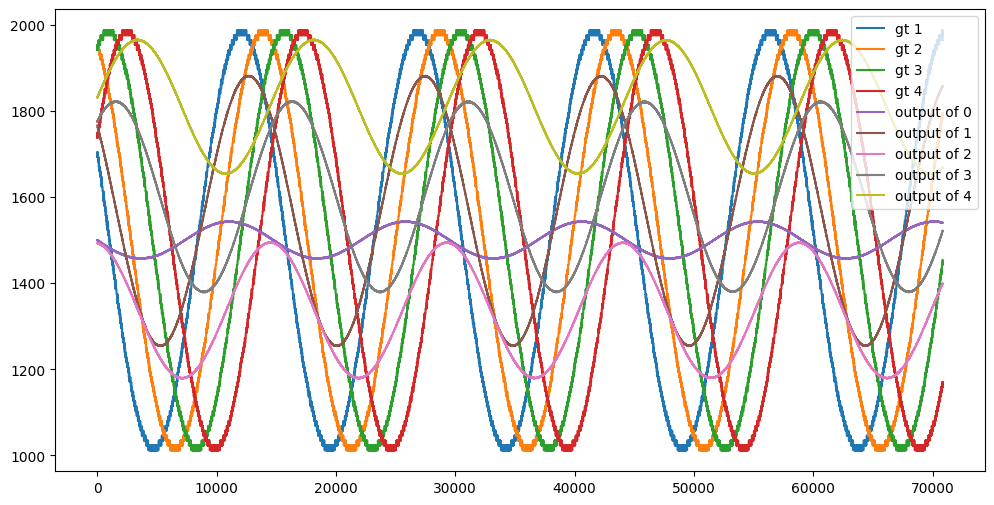

In [81]:
freq0 = 104
clk_freq = 1536000
duration = .6 * clk_freq / 1536000
lf = 5
cycles = 5


phase_shift = 0
ground_truth = []

# phis = [0, 43.6, 44.1, 43.5, 37.7] # for spiking window of 500
spikes_window_size = 3000
phis = [0, 25.6, 44.1, 43.5, 37.7] # for spiking window of 3000
max_xi = 1987
min_xi = 1012
plt.figure(figsize=(12,6))

base_params = {'theta_input': -5,
 'theta1': -3,
 'theta2': -6,
 'theta3': -3,
 'weight_input': 26,
 'weight_feedback': 13,
 'weight1': 5,
 'weight2': 14,
 'weight3': 7}

# base_params = {
#     'theta_input': -1,
#  'weight_input': 11,
#  'weight_feedback': 9,
#  'theta1': -5,
#  'theta2': -5,
#  'theta3': -5,
#  'weight1': 10,
#  'weight2': 10,
#  'weight3': 10
#                }
# base_params = {
#     'theta_input': -8,
#     'theta1': -6,
#     'theta2': -6,
#     'theta3': -6,
#     'weight_input': 20,
#     'weight_feedback': 4,
#     'weight1': 12,
#     'weight2': 12,
#     'weight3': 12,
# }
desired_resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf, clk_freq=clk_freq)
for i in range(0, 5):
    desired_resonator.log_out_spikes(i)
generate_and_input_signal(desired_resonator, duration, freq0)
for i in range(1, 5):
    phase_shift -= phis[i]
    gt_i = neuron_output(desired_resonator.neurons[0], spikes_window_size, duration, freq0, phase_shift, cycles=cycles)
    gt_i = (gt_i - gt_i.min())/(gt_i.max() - gt_i.min())
    gt_i = gt_i * (max_xi - min_xi) + min_xi
    ground_truth.append(gt_i)
    plt.plot(gt_i, label=f'gt {i}')

for i in range(1, 5):
    ni = neuron_output(desired_resonator.neurons[i], spikes_window_size, duration, freq0, 0, cycles=cycles)
    print(f'{i}: Max {ni.max()}, Mean {ni.mean()}, Min {ni.min()}')
ground_truth = np.array(ground_truth)
n0 = neuron_output(desired_resonator.neurons[0], spikes_window_size, duration, freq0, 0, cycles=cycles)
desired_resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf, clk_freq=clk_freq)
mse = score_resonator(desired_resonator, duration=duration, freq0=freq0, plot=True, cycles=cycles)
print(f'base parameters mse {mse}')


In [82]:
for i in range(0, 4):
    print(f'{i}: Max {ground_truth[i].max()}, Mean {ground_truth[i].mean()}, Min {ground_truth[i].min()}')

0: Max 1987.0, Mean 1482.6804511722441, Min 1012.0
1: Max 1987.0, Mean 1481.0832757255623, Min 1012.0
2: Max 1987.0, Mean 1489.7071590210812, Min 1012.0
3: Max 1987.0, Mean 1501.7625451999434, Min 1012.0


In [83]:
2004-1428, 1428-894, 1987 - 1482, 1482-1012, 1012-894

(576, 534, 505, 470, 118)

In [86]:
from optuna.samplers import CmaEsSampler, GridSampler, NSGAIISampler
from optuna.distributions import DiscreteUniformDistribution
import time

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            # sampler=CmaEsSampler(
                            sampler=TPESampler(
                                seed=43,
                                n_startup_trials=50,
                                # consider_prior=DiscreteUniformDistribution()
                                ),
                            direction='minimize',
                            load_if_exists=True)

# study.enqueue_trial(
    # {
    #     'theta_input': -5,
    #     'theta1': -5,
    #     'theta2': -5,
    #     'theta3': -5,
    #     'weight_input': 11,
    #     'weight_feedback': 9,
    #     'weight1': 10,
    #     'weight2': 10,
    #     'weight3': 10,
    #  }
# )

[I 2023-06-22 16:02:18,284] A new study created in memory with name: Study1536000-104


In [87]:
ts = time.time()
# study.optimize(objective, n_trials=300)
# study.optimize(objective5, n_trials=300)
study.optimize(objective3, n_trials=300)
print(f'{time.time() - ts} seconds.')

[I 2023-06-22 16:02:22,424] Trial 0 finished with value: inf and parameters: {'weight_input': 4, 'weight_feedback': 10, 'weight': 3}. Best is trial 0 with value: inf.
[I 2023-06-22 16:02:23,882] Trial 1 finished with value: 3237655.959622409 and parameters: {'weight_input': 7, 'weight_feedback': 5, 'weight': 18}. Best is trial 1 with value: 3237655.959622409.
[I 2023-06-22 16:02:25,270] Trial 2 finished with value: inf and parameters: {'weight_input': 18, 'weight_feedback': 9, 'weight': 1}. Best is trial 1 with value: 3237655.959622409.
[I 2023-06-22 16:02:26,772] Trial 3 finished with value: 8898211.22820428 and parameters: {'weight_input': 20, 'weight_feedback': 6, 'weight': 17}. Best is trial 1 with value: 3237655.959622409.
[I 2023-06-22 16:02:28,218] Trial 4 finished with value: 7707794.986494547 and parameters: {'weight_input': 7, 'weight_feedback': 1, 'weight': 18}. Best is trial 1 with value: 3237655.959622409.
[I 2023-06-22 16:02:29,666] Trial 5 finished with value: 2876236.91

221.4508752822876 seconds.


mse 3524.240388240955


{'weight_input': 11,
 'weight_feedback': 9,
 'theta_input': -1,
 'theta1': -5,
 'theta2': -5,
 'theta3': -5,
 'weight1': 10,
 'weight2': 10,
 'weight3': 10}

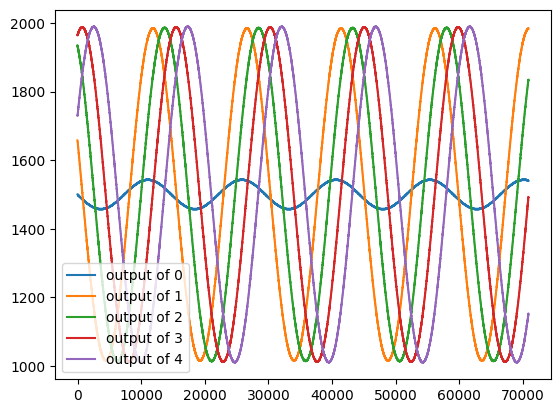

In [89]:
# 118 {'theta_input': -1.161, 'theta': -4.943, 'weight_input': 8.512, 'weight_feedback': 8.867, 'weight': 10.342}
# 10.4 {'theta_input': -8, 'theta': -6, 'weight_input': 20, 'weight_feedback': 4,  'weight': 12}
def objective5_params_to_resonator(params):
    if len(params) > 5:
        return params

    if len(params) == 3:
        params['theta_input'] = -1
        params['theta'] = -5

    params['theta1'] = params['theta']
    params['theta2'] = params['theta']
    params['theta3'] = params['theta']
    params['weight1'] = params['weight']
    params['weight2'] = params['weight']
    params['weight3'] = params['weight']
    del params['theta']
    del params['weight']
    return params

best_params = objective5_params_to_resonator(study.best_params.copy())

resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, clk_freq=clk_freq)
mse = score_resonator(resonator, duration=duration, freq0=freq0, plot=True)
print(f'mse {mse}')
best_params

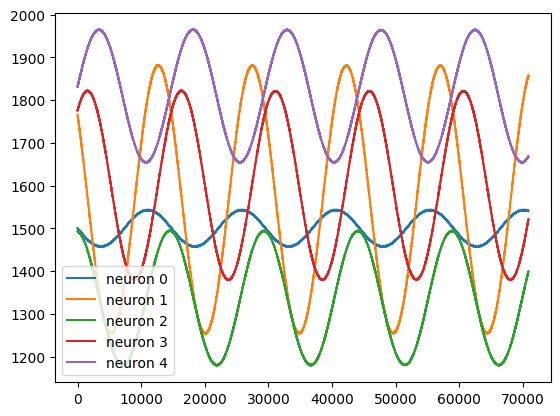

In [76]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


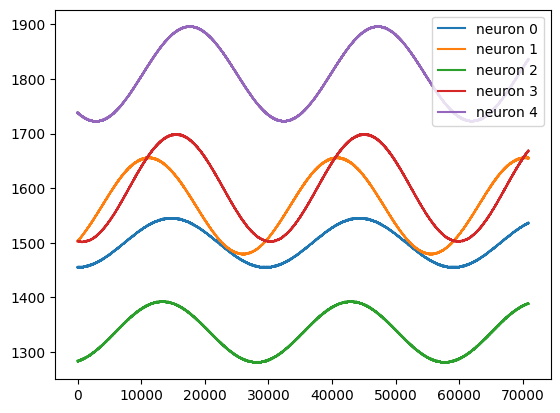

In [77]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)


generate_and_input_signal(resonator, duration, freq0 / 2)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


peak: 93.8062243597451


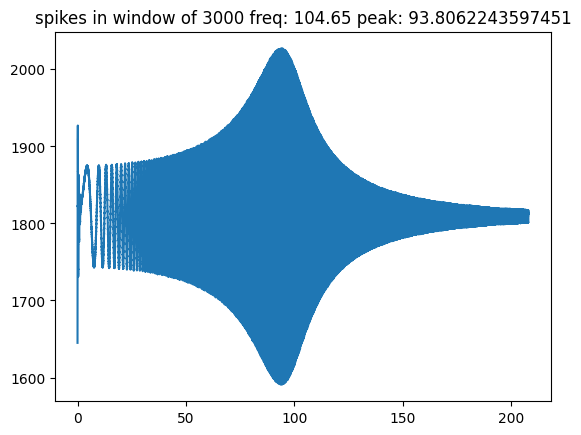

In [78]:

start_freq = 0
spectrum = 2 * freq0
# best_params = base_params
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
print(f'peak: {x[1000+np.argmax(y_spikes[1000:])]}')

best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} peak: {x[1000+np.argmax(y_spikes[1000:])]}')
plt.plot(x, y_spikes)
plt.show()

## Phase shift by 45 - 1 neuron

In [3]:

def phase_shift45_network(lf, weight, theta):
    lp = lp_by_lf(lf, freq0, clk_freq)

    network = SpikingNetwork(clk_freq)
    network.add_amplitude(10000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight], dtype=np.float64)
    neuron.leakage_factor = lf
    neuron.leakage_period = lp
    neuron.theta = theta
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))
    return network


def phase_shift180_network(lf, weight, theta):
    lp = lp_by_lf(lf, freq0, clk_freq)

    network = SpikingNetwork(clk_freq)
    network.add_amplitude(10000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    for i in range(4):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = lf
        neuron.leakage_period = lp
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))
    return network

mse: 56577.48733435131


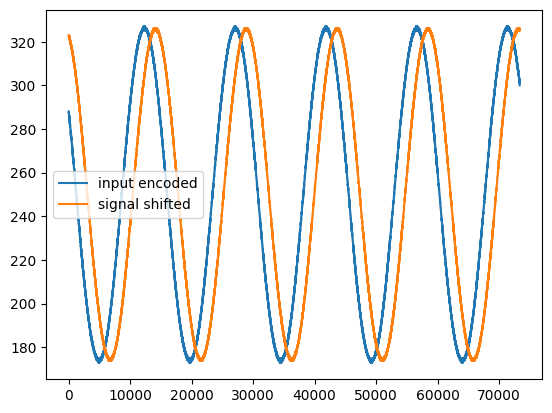

In [10]:
freq0 = 104
clk_freq = 1536000
duration = .6
spikes_window_size = 500
cycles = 5

params = {'lf': 4, 'weight': 20, 'theta': -10}
shift_network = phase_shift45_network(**params)
shift_network.log_out_spikes(0)
shift_network.log_out_spikes(-1)

generate_and_input_signal(shift_network, duration, freq0)
phase_shift = -45
input_encoded = neuron_output(shift_network.neurons[0], spikes_window_size, duration, freq0, cycles=cycles)
signal_shifted = neuron_output(shift_network.neurons[1], spikes_window_size, duration, freq0, cycles=cycles)
ground_truth = neuron_output(shift_network.neurons[0], spikes_window_size, duration, freq0, phase_shift, cycles=cycles)
plt.plot(input_encoded, label=f'input encoded')
# plt.plot(ground_truth, label=f'input shifted')
plt.plot(signal_shifted, label=f'signal shifted')
plt.legend()

mse = ((signal_shifted - ground_truth)**2).mean()

ampl0 = signal_shifted.max() - signal_shifted.min()
# now start check other frequencies onlt the amplitude
for freq  in [1/5, 1/3, 1/2, 2/3, 3/2, 2, 3]:
    freq *= freq0
    shift_network.forget_logs()
    generate_and_input_signal(shift_network, duration, freq)
    try:
        signal = neuron_output(shift_network.neurons[1], spikes_window_size, duration, freq, cycles=cycles)
    except ValueError:
        mse += np.inf
        break
    ampl = signal.max() - signal.min()
    mse += (ampl - ampl0)**2
print(f'mse: {mse}')

In [18]:
from snn.resonator import lp_by_lf, freq_of_resonator

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=TPESampler(
                                seed=43,
                                n_startup_trials=50,
                                ),
                            direction='minimize',
                            load_if_exists=True)

def objective_phase_shift_45(trial):
    shift_network = phase_shift45_network(
        trial.suggest_int('lf', 3, 6),
        trial.suggest_int('weight', 1, 20),
        trial.suggest_int('theta', -10, -1)
    )
    # shift_network.log_out_spikes(0)
    shift_network.log_out_spikes(-1)

    generate_and_input_signal(shift_network, duration, freq0)
    try:
        signal_shifted = neuron_output(shift_network.neurons[1], spikes_window_size, duration, freq0, cycles=cycles)
    except ValueError:
        return np.inf
    mse = ((signal_shifted - ground_truth)**2).mean()
    ampl0 = signal_shifted.max() - signal_shifted.min()
    # now start check other frequencies onlt the amplitude
    for freq  in [1/3, 2/3, 4/3, 5/3]:
        freq *= freq0
        shift_network.forget_logs()
        generate_and_input_signal(shift_network, duration, freq)
        try:
            signal = neuron_output(shift_network.neurons[1], spikes_window_size, duration, freq, cycles=cycles)
        except ValueError:
            return np.inf
        ampl = signal.max() - signal.min()
        mse += (ampl - ampl0)**2
    return mse


[I 2023-06-24 21:46:28,934] A new study created in memory with name: Study1536000-104


In [22]:
import time
ts = time.time()
study.optimize(objective_phase_shift_45, n_trials=300)
print(f'{time.time() - ts} seconds.')
study.best_params

[I 2023-06-24 22:17:03,551] Trial 221 finished with value: 1902.6763783606914 and parameters: {'lf': 3, 'weight': 13, 'theta': -7}. Best is trial 119 with value: 1823.7433876860991.
[I 2023-06-24 22:17:11,629] Trial 222 finished with value: 1823.7433876860991 and parameters: {'lf': 3, 'weight': 14, 'theta': -7}. Best is trial 119 with value: 1823.7433876860991.
[I 2023-06-24 22:17:19,690] Trial 223 finished with value: 1823.7433876860991 and parameters: {'lf': 3, 'weight': 14, 'theta': -7}. Best is trial 119 with value: 1823.7433876860991.
[I 2023-06-24 22:17:27,775] Trial 224 finished with value: 1823.7433876860991 and parameters: {'lf': 3, 'weight': 14, 'theta': -7}. Best is trial 119 with value: 1823.7433876860991.
[I 2023-06-24 22:17:35,884] Trial 225 finished with value: 1823.7433876860991 and parameters: {'lf': 3, 'weight': 14, 'theta': -7}. Best is trial 119 with value: 1823.7433876860991.
[I 2023-06-24 22:17:43,947] Trial 226 finished with value: 1912.4046463434586 and paramete

10923.093528032303 seconds.


{'lf': 3, 'weight': 14, 'theta': -7}

In [20]:
study.best_params

{'lf': 3, 'weight': 14, 'theta': -7}

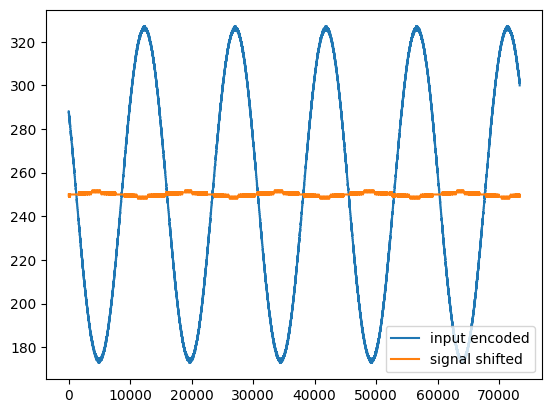

In [21]:
# params = {'lf': 4, 'weight': 20, 'theta': -10}
params = study.best_params
shift_network = phase_shift180_network(**params)
shift_network.log_out_spikes(0)
shift_network.log_out_spikes(-1)

generate_and_input_signal(shift_network, duration, freq0)
input_encoded = neuron_output(shift_network.neurons[0], spikes_window_size, duration, freq0, cycles=cycles)
signal_shifted = neuron_output(shift_network.neurons[-1], spikes_window_size, duration, freq0, cycles=cycles)
plt.plot(input_encoded, label=f'input encoded')
plt.plot(signal_shifted, label=f'signal shifted')
plt.legend()